In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import torch.distributions as dist
import torch.nn.functional as F
from torch import cuda
from torch.backends import mps
from collections import deque
import matplotlib.pyplot as plt
import time

def get_device() -> str:
    """ Get Device Name """
    if cuda.is_available():
        return "cuda"
    elif mps.is_available():
        return "mps"
    else:
        return "cpu"
    
def typeprint(var):
    print(type(var))
    print(var)

class Logger:
    episodes = []
    optimal = []
    optimaleps = []

    actions = []

    def __init__(self):
        self.episodes.append(["t", "length", "reward"])
        self.optimal.append(["t", "avg"])
        self.optimaleps.append(["t", "reward"])

    # def addep(self, t, length, reward):

    def export(self, agent):
        name = "tests\\" + str(int(time.time()))
        with open(name + "_eps.csv", "w") as file:
            for ep in self.episodes:
                file.write(",".join([str(x) for x in ep]) + "\n")
        with open(name + "_optim.csv", "w") as file:
            for data in self.optimal:
                file.write(",".join([str(x) for x in data]) + "\n")
        with open(name + "_optim_eps.csv", "w") as file:
            for data in self.optimaleps:
                file.write(",".join([str(x) for x in data]) + "\n")
        with open(name + "_info.txt", "w") as file:
            file.write(f"entropy Start (alpha): {agent.entropy}\n")
            file.write(f"entropy zero(alpha): {agent.entropy}\n")
            file.write(f"discount (gamma): {agent.discount}\n")
            file.write(f"polyak (1-tau): {agent.polyak}\n")
            file.write(f"learning rate: {agent.l_rate}\n")
            file.write(f"network structure: {agent.hidden}\n")
            file.write(f"minibatch size: {agent.batch_size}\n")



# Stores experiences from the agent
# State - current state
# Action - action performed in that state
# Reward - reward gained from taking the action in the state
# Next State - the state resulting from taking the action from that state
# Done - done signal, true if the next state is terminal, if both legs are touched down
class ReplayBuffer:
    def __init__(self):
        self.buffer = []
        self.maxlen = 50000
    
    def new_memory(self, state, action, reward, next, done):
        self.buffer.append((state, action, reward, next, done))
        if len(self.buffer) > self.maxlen: self.buffer.pop(0)

    # returns a random permutation of a range with the length of the buffer
    def rand_key(self):
        memories = range(len(self.buffer))
        return np.random.permutation(np.array(memories))

    # returns a random selection of the memory
    def rand_sample(self, size):
        sample = []
        for i in self.rand_key()[:size]:
            sample.append(self.buffer[i])
        return sample
    
    def rand_sample_split(self, size):
        state, action, reward, next, done = [], [], [], [], []
        for item in self.rand_sample(size):
            state.append(item[0])
            action.append(item[1])
            reward.append(item[2])
            next.append(item[3])
            done.append(item[4])
        return np.array(state), np.array(action), np.array(reward), np.array(next), np.array(done)

    def rand_batches(self, size):
        key = self.rand_key()
        memories = len(key)
        index = 0
        batches = []
        while index < memories:
            batch = []
            for _ in range(min(size, memories - index)):
                batch.append(self.buffer[key[index]])
            batches.append(batch)


class ActorNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[500, 500], l_rate=0.0003):
        super(ActorNet, self).__init__()

        # Set up layers
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            # layers.append(nn.LeakyReLU())
            layers.append(nn.ReLU())
            prev_dim = dim
        self.network = nn.Sequential(*layers)
        # self.mean_layer = nn.Sequential(nn.Linear(prev_dim, output_dim), nn.Tanh())
        self.mean_layer = nn.Linear(prev_dim, output_dim)
        # self.logstd_layer = nn.Sequential(nn.Linear(prev_dim, output_dim), nn.Softplus())
        self.logstd_layer = nn.Linear(prev_dim, output_dim)

        # self.optimizer = optim.Adam(self.parameters(), lr = l_rate)
        self.optimizer = optim.Adam(self.parameters(), lr = l_rate)

    # gets a mean and standard deviation value for each action
    def forward(self, state):
        output = self.network(state)
        mean = self.mean_layer(output)

        # maybe experiment with clamp values
        logstd = torch.clamp(self.logstd_layer(output), -3, 2)

        return mean, logstd
    
    def sample_normal(self, state):
        mean, logstd = self.forward(state)
        std = logstd.exp()
        dist = torch.distributions.Normal(mean, std)
        sample = dist.rsample() # used to just be sample, source of all my problems?
        action = torch.tanh(sample)

        log_prob = dist.log_prob(sample)
        log_pi = torch.sum(log_prob, dim=1, keepdim=True)
        return action, log_pi
    
class CriticNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[500, 500], l_rate=0.0003):
        super(CriticNet, self).__init__()

        # Set up layers
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            # layers.append(nn.LeakyReLU())
            layers.append(nn.ReLU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

        self.optimizer = optim.Adam(self.parameters(), lr = l_rate)

    def forward(self, action, state):
        input = torch.cat((action, state), dim=1)
        output = self.network(input)
        return output


class SACAgent:
    def __init__(self, env: gym.Env):

        self.device = torch.device(get_device())
        self.env = env
        input_dim = env.observation_space.shape[0]
        output_dim = env.action_space.shape[0]

        self.memory = ReplayBuffer()
        # self.valloss = []
        self.crit1loss = []
        self.crit2loss = []
        self.actorloss = []


        # new stuff vv
        self.entropystart = 0.3 # alpha 0.2 start
        self.entropy = self.entropystart
        self.entropyzero = -1
        self.discount = 0.99 # gamma
        self.polyak = 0.99 # 1 - tau
        l_rate = 0.0003
        hidden = [512, 512]

        # for logging
        self.l_rate = l_rate
        self.hidden = hidden

        self.batch_size = 128

        self.actor = ActorNet(input_dim, output_dim, l_rate=l_rate, hidden_dims=hidden).to(self.device)
        self.critic1 = CriticNet(input_dim + output_dim, l_rate=l_rate, hidden_dims=hidden).to(self.device)
        self.critic2 = CriticNet(input_dim + output_dim, l_rate=l_rate, hidden_dims=hidden).to(self.device)
        self.critic1tar = CriticNet(input_dim + output_dim, l_rate=l_rate, hidden_dims=hidden).to(self.device)
        self.critic2tar = CriticNet(input_dim + output_dim, l_rate=l_rate, hidden_dims=hidden).to(self.device)

        # initializing target networks to equal the live ones
        for target, live in zip(self.critic1.parameters(), self.critic1tar.parameters()):
            target.data.copy_(live.data)
        for target, live in zip(self.critic2.parameters(), self.critic2tar.parameters()):
            target.data.copy_(live.data)

        # maybe some stuff here about optimizing alpha??

    def get_tensor (self, array):
        return torch.from_numpy(array).float().to(self.device)
    
    def get_numpy(self, tensor):
        return tensor.cpu().detach().numpy()

    def get_action(self, state):
        state_tensor = self.get_tensor(state)
        action, std = self.actor.sample_normal(state_tensor)
        return action, std
    
    def get_single_action(self, state):
        state_tensor = self.get_tensor(state).unsqueeze(0)
        action, std = self.actor.sample_normal(state_tensor)
        return self.get_numpy(action.squeeze()), std
    
    def printstatus(self, t, rewards, ends, lens):
        index = -min(len(ends), 10)
        bindex = -min(len(ends), 100)
        output = "Ep: " + str(len(ends))
        output += ", Reward: " + str(int(rewards[-1]))
        output += ", Ep start: " + str(t)
        output += ", avg reward: " + str(int(sum(rewards[index:])/-index))
        output += ", avg len: " + str(int(sum(lens[index:])/-index)) + "  "
        # output += ", truncated: " + str(sum(ends[bindex:])) + "%  "
        print("\r" + output, end="")

    def run_ep(self, t):

        terminal = False
        state = self.env.reset()[0]
        epreward = 0
        while not terminal:
            action, _ = self.actor.forward(self.get_tensor(state))
            state, reward, isterminal, truncated, _ = self.env.step(self.get_numpy(action))
            terminal = isterminal or truncated
            epreward += reward
        logger.optimaleps.append([t, epreward])
        return epreward
    
    def runs_avg(self, runs, t):
        rewards = []
        for _ in range(runs):
            rewards.append(self.run_ep(t))
        avg = sum(rewards)/runs
        logger.optimal.append([t, avg])
        return avg

    def train(self, episodes, maxsteps=200000, exploration=4000):
        reward_hist = []
        ends = []
        lens = []
        ep_start = 0
        total_reward = 0
        terminal = False
        current_state = self.env.reset()[0]
        for t in range(maxsteps):
            if len(ends) >= episodes: 
                break
            if t % 4000 == 0:
                print("real score: " + str(int(self.runs_avg(100, t))))
            if terminal:
                # current_state = self.env.reset(seed=1)[0]
                current_state = self.env.reset()[0]

                reward_hist.append(total_reward)
                ends.append(truncated)
                lens.append(t-ep_start)
                self.printstatus(t, reward_hist, ends, lens)

                # logging
                logger.episodes.append([t, t-ep_start, total_reward])
                

                total_reward = 0
                ep_start = t

            
            if t < exploration:
                action = self.env.action_space.sample()
            else:
                action, _ = self.get_single_action(current_state)
            logger.actions.append(action)
            next_state, reward, isterminal, truncated, _ = self.env.step(action)
            total_reward += reward
            terminal = 1 if isterminal or truncated else 0
            self.memory.new_memory(current_state, action, reward, next_state, terminal)
            current_state = next_state
            if self.entropyzero > 0: self.entropy = max(0, self.entropystart * (1 - (len(lens)/episodes) / self.entropyzero))
            if t == exploration: 
                for _ in range(100): self.train_networks()
            if t > exploration:
                self.train_networks()
                self.train_networks()
        print()
        return reward_hist

    # memory: 0 state, 1 action, 2 reward, 3 next, 4 done
    def train_networks(self):
        states, actions, rewards, nexts, dones = self.memory.rand_sample_split(self.batch_size)
        states = self.get_tensor(states)
        actions = self.get_tensor(actions)
        rewards = self.get_tensor(rewards).unsqueeze(1)
        nexts = self.get_tensor(nexts)
        dones = self.get_tensor(dones).unsqueeze(1)
        # print(states[0])
        # print(actions[0])
        # print(rewards[0])
        # print(nexts[0])
        # print(dones[0])

        # getting sample actions using the next states
        next_act, next_log_prob = self.actor.sample_normal(nexts)

        # getting the critic targets
        next_q1 = self.critic1tar.forward(next_act, nexts)
        next_q2 = self.critic2tar.forward(next_act, nexts)
        next_q = torch.min(next_q1, next_q2) - self.entropy * next_log_prob
        # not sure if i need to detach, not done in other places
        tar_q = rewards + (1-dones) * self.discount * next_q.detach()

        curr_q1 = self.critic1.forward(actions, states)
        crit_loss1 = torch.nn.functional.mse_loss(curr_q1, tar_q)
        self.crit1loss.append(self.get_numpy(crit_loss1))
        self.critic1.optimizer.zero_grad()
        crit_loss1.backward()
        self.critic1.optimizer.step()
        
        curr_q2 = self.critic2.forward(actions, states)
        crit_loss2 = torch.nn.functional.mse_loss(curr_q2, tar_q)
        self.crit2loss.append(self.get_numpy(crit_loss2))
        self.critic2.optimizer.zero_grad()
        crit_loss2.backward()
        self.critic2.optimizer.step()

        sample_act, sample_log_prob = self.actor.sample_normal(states)
        act_q1 = self.critic1.forward(sample_act, states)
        act_q2 = self.critic2.forward(sample_act, states)
        act_q = torch.min(act_q1, act_q2)
        act_loss = (self.entropy * sample_log_prob) - act_q
        act_loss = torch.mean(act_loss)
        self.actorloss.append(self.get_numpy(act_loss))
        self.actor.optimizer.zero_grad()
        act_loss.backward()
        self.actor.optimizer.step()

        self.polyak_update()

        # maybe some stuff about optimizing alpha


    def polyak_update(self):
        for target, real in zip(self.critic1tar.parameters(), self.critic1.parameters()):
            target.data.copy_((self.polyak * target.data) + ((1-self.polyak) * real.data))
        for target, real in zip(self.critic2tar.parameters(), self.critic2.parameters()):
            target.data.copy_((self.polyak * target.data) + ((1-self.polyak) * real.data))

logger = Logger()
   

In [2]:
#  # env: gym.Env, batch_size, discount, start_training, polyak, entropy
# def main():
env = gym.make("LunarLander-v2", 
        continuous=True)
print("using " + get_device())
# torch.autograd.set_detect_anomaly(True)
# print(env.action_space)
# print(env.action_space.shape)
# print(env.observation_space)
# print(env.observation_space.shape[0])
# print(env.reset()[0])
# print(type(env.reset()[0]))
agent = SACAgent(env)
rewards = agent.train(1200, maxsteps=20000000, exploration=4000)
logger.export(agent)

using cuda
real score: -254
Ep: 36, Reward: -261, Ep start: 3918, avg reward: -245, avg len: 116  real score: -247
Ep: 43, Reward: -123, Ep start: 7598, avg reward: -228, avg len: 396  real score: -170
Ep: 48, Reward: -61, Ep start: 11577, avg reward: -118, avg len: 746  real score: -51
Ep: 52, Reward: -78, Ep start: 15001, avg reward: -73, avg len: 840  real score: -294
Ep: 57, Reward: -193, Ep start: 19912, avg reward: -113, avg len: 933  real score: -213
Ep: 61, Reward: -152, Ep start: 23001, avg reward: -132, avg len: 900  real score: -109
Ep: 66, Reward: -233, Ep start: 27279, avg reward: -105, avg len: 836  real score: -231
Ep: 70, Reward: -93, Ep start: 31001, avg reward: -110, avg len: 900   real score: -97
Ep: 74, Reward: -56, Ep start: 35001, avg reward: -90, avg len: 954    real score: -65
Ep: 78, Reward: -48, Ep start: 39001, avg reward: -75, avg len: 1000  real score: -96
Ep: 82, Reward: -84, Ep start: 43001, avg reward: -65, avg len: 1000  real score: -63
Ep: 86, Reward: 


1200


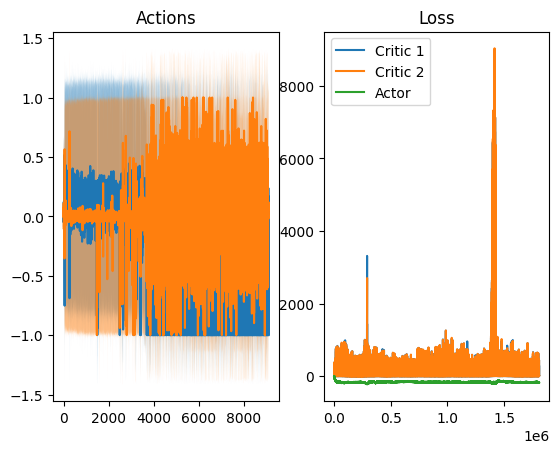

In [3]:

# print("final avg score: " + str(agent.runs_avg(100)))
# exit()
i = 0
batch = 100
# print(len(logger.actions))
# print(logger.actions[0])
# logger.actions = np.array(logger.actions)
act_mean = []
act_std = []
while i + batch < len(logger.actions):
    arr = np.array(logger.actions[i:i+batch])
    # arr.mean()
    # print(arr.mean())
    # print(arr.std())
    # print(arr.mean(axis=0))
    # print(arr.std(axis=0))
    act_mean.append(arr.mean(axis=0))
    act_std.append(arr.std(axis=0))
    i += batch

print()
print(len(rewards))
# plt.subplot(1, 2, 1)
# plt.title("Episode Rewards")
# plt.plot(rewards)
# plt.title("Gradient Norms")
# plt.plot(valgrads, label="Value")
# plt.plot(crit1grads, label="Critic 1")
# plt.plot(crit2grads, label="Critic 2")
# plt.plot(actgrads, label="Actor")
plt.subplot(1, 2, 1)
plt.title("Actions")
m = np.array([x[0] for x in act_mean])
d = np.array([x[0] for x in act_std])
plt.plot(m, label="Action 0 Mean")
plt.fill_between(range(len(m)), m-d, m+d, label="Action 0 Std Dev", alpha=0.5)
m = np.array([x[1] for x in act_mean])
d = np.array([x[1] for x in act_std])
plt.plot(m, label="Action 1 Mean")
plt.fill_between(range(len(m)), m-d, m+d, label="Action 1 Std Dev", alpha=0.5)
# plt.plot([x[0] for x in act_std], label="Action 0 Std Dev", color="blue")
# plt.plot([x[1] for x in act_mean], label="Action 1 Mean", color="orange")
# plt.plot([x[1] for x in act_std], label="Action 1 Std Dev", color="red")
# plt.plot(, label="")
# plt.plot(, label="")
# plt.plot(, label="")
# plt.plot(, label="")
plt.subplot(1, 2, 2)
plt.title("Loss")
# plt.plot(agent.valloss, label="Value")
plt.plot(agent.crit1loss, label="Critic 1")
plt.plot(agent.crit2loss, label="Critic 2")
plt.plot(agent.actorloss, label="Actor")
plt.legend()
plt.show()
    # print(len(agent.memory.buffer))
    # print(agent.get_action(env.reset()[0]))



